## Notebook for student Graph — Build, Visualize, Analyze

**Goal**  
We build a student-to-student graph from VLE activity (clicks), detect communities,
and analyze if these communities relate to academic outcomes (final_result)

**Dataset used**  
OULAD tables: studentVle, studentInfo, courses, assessments, studentAssessment

### Part 1 : import and config

In [57]:
import sys, os, importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE

# to import from ../src because we occur some problem 
sys.path.insert(0, os.path.abspath('..'))

import src.data_preprocessing as dp
import src.graph_students as gs

# re-load in because we editing the .py files several time
importlib.reload(dp)
importlib.reload(gs)


DATA_DIR = "../data"
MODULE = "AAA"          # just one module, e.g. "AAA"
PRESENTATION = "2013J"  # just one presentation, e.g. "2013J"

# graph params 
K_NEIGHBORS = 10
SIM_THRESHOLD = 0.20


#### Step 2 : import and prepare data

- student_data
- activity_matrix
- assessment_data

In [47]:
student_data, X_raw, assess = dp.load_and_prepare_oulad(
    data_dir=DATA_DIR,
    module=MODULE,
    presentation=PRESENTATION,
)

print("student_data:", student_data.shape)
print("activity_matrix (X_raw):", X_raw.shape)
print("assessment rows:", assess.shape)
display(student_data.head())
display(X_raw.head())


student_data: (32593, 15)
activity_matrix (X_raw): (378, 209)
assessment rows: (172003, 10)


,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,11391,-159.0,NaN,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268
1,AAA,2013J,28400,-53.0,NaN,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,268
2,AAA,2013J,30268,-92.0,12.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,268
3,AAA,2013J,31604,-52.0,NaN,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,268
4,AAA,2013J,32885,-176.0,NaN,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,268


id_site,546614,546644,546645,546647,546648,546649,546650,546651,546652,546653,...,547038,547040,547042,547043,547047,547048,547049,547050,547066,547067
id_student,,,,,,,,,,,,,,,,,,,,,
11391,138,35,15,9,0,0,10,0,28,0,...,0,0,0,0,0,0,0,0,0,0
28400,324,21,21,4,2,8,27,22,89,6,...,0,0,0,0,1,9,0,0,0,0
30268,59,0,7,0,0,0,1,0,46,0,...,0,0,0,0,0,0,0,0,0,0
31604,432,169,16,19,10,17,0,45,30,11,...,0,0,0,0,0,2,0,0,0,0
32885,204,17,3,7,0,0,7,0,107,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
X = dp.normalize_rows_max(X_raw)

### Part 3 : Normalize activity + simularty matrix 

In [51]:
X = dp.normalize_rows_max(X_raw)
sim = gs.build_similarity_matrix(X)

print("Shape of similarity matrix:", sim.shape)
print("\n", sim)

Shape of similarity matrix: (378, 378)

 [[0.         0.61243118 0.47146375 ... 0.58346802 0.50976898 0.70380131]
 [0.61243118 0.         0.72173078 ... 0.85809037 0.83265758 0.88497294]
 [0.47146375 0.72173078 0.         ... 0.61370807 0.63473579 0.66593669]
 ...
 [0.58346802 0.85809037 0.61370807 ... 0.         0.81258941 0.85645759]
 [0.50976898 0.83265758 0.63473579 ... 0.81258941 0.         0.84485704]
 [0.70380131 0.88497294 0.66593669 ... 0.85645759 0.84485704 0.        ]]


### Part 4 : Build graph + communities 

Nb of edges : 378
Nb og link: 3053
Density of the graphe : 0.0428
Modularity : 0.481
Community detected: 3


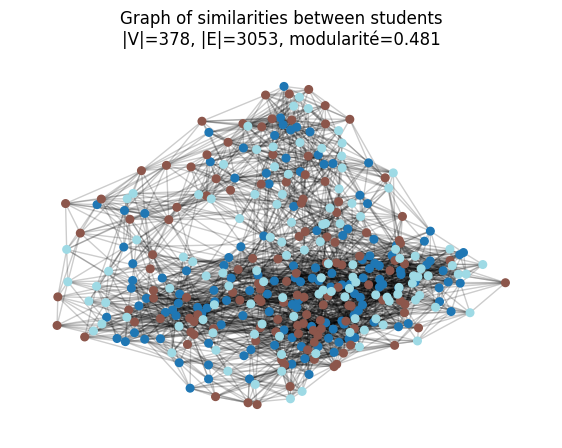

In [65]:
G = gs.build_knn_graph(
    sim,
    student_ids=X.index.tolist(),
    k=K_NEIGHBORS,
    sim_threshold=SIM_THRESHOLD
)

# community detection => Louvain if available else greedy
part = gs.detect_communities(G)
modularity = gs.compute_modularity(G, part)

# little analyse 
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
density = nx.density(G)  

print(f"Nb of edges : {nb_nodes}")
print(f"Nb og link: {nb_edges}")
print(f"Density of the graphe : {density:.4f}")
print(f"Modularity : {modularity:.3f}")
print(f"Community detected: {len(set(part.values()))}")

plt.figure(figsize=(7, 5))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=30, node_color=list(part.values()), cmap='tab20')
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title(f"Graph of similarities between students\n|V|={nb_nodes}, |E|={nb_edges}, modularité={modularity:.3f}")
plt.axis("off")
plt.show()


This graph represents the **similarities between 378 students** in the module *AAA - 2013J*.

- **|V| = 378** → number of students  
- **|E| = 3053** → number of similarity links between them  
- **Density = 0.0428** → the network is **quite sparse**, which means that most students have **different learning patterns** on the platform.  
  Only a few students show very similar behaviors.  
- **Modularity = 0.481** → there is a **moderate community structure**:  
  some clear groups of students behave similarly, but the boundaries between groups are **not strict**.  
  Some students have mixed or intermediate behaviors.  
- **3 communities detected** → these represent 3 main learning profiles.

**Interpretation:**  
The network suggests that students are **diverse in their study habits**, but some groups share similar ways of using the VLE.  
We can identify about 3 main communities and we can think they are constructed as that:
1. Highly active students (many interactions)  
2. Moderately active students  
3. Low-activity or irregular students

### Part 5 : Vizualise just a sample of the network 

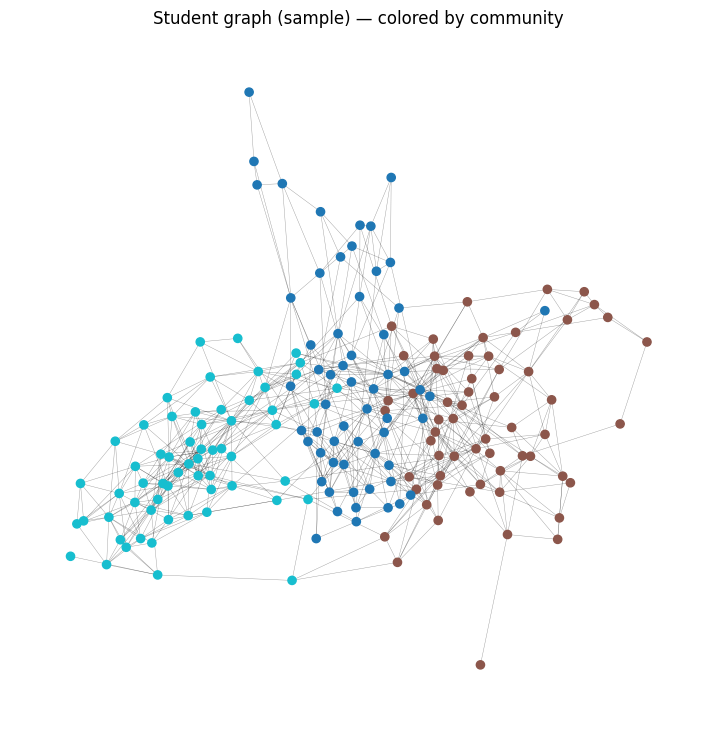

In [ ]:
# for a better visualisation we decide to analyse here the largest component connexe
components = list(nx.connected_components(G))
largest_cc = max(components, key=len)
G_cc = G.subgraph(largest_cc).copy() 

# but there still are a lot of node qo we take a subsample og the composent connexe 
random.seed(42)
N_SAMPLE = 180
nodes_cc = list(G_cc.nodes())
if len(nodes_cc) > N_SAMPLE:
    sampled_nodes = set(random.sample(nodes_cc, N_SAMPLE))
    G_draw = G_cc.subgraph(sampled_nodes).copy()
else:
    G_draw = G_cc

# colors by community
part_series = pd.Series(part) 
comm_map = part_series.loc[list(G_draw.nodes())].astype(int)

# small color map
unique_comms = sorted(comm_map.unique())
color_lookup = {c:i for i,c in enumerate(unique_comms)}
node_colors = [color_lookup[c] for c in comm_map]

# draw
plt.figure(figsize=(9, 9))
pos = nx.spring_layout(G_draw, seed=42, weight="weight", k=0.15)
nx.draw_networkx_nodes(G_draw, pos, node_size=35, node_color=node_colors, cmap="tab10")
nx.draw_networkx_edges(G_draw, pos, width=0.3, alpha=0.4)
plt.title("Student graph (sample) — colored by community")
plt.axis("off")
plt.show()


This figure shows a **sample of 180 students** from the largest connected part of the network. Each point is one student, and each line represents a **similarity** between two students.  
The **color** indicates the **community** detected by the algorithm.

We can see the **3 main groups** find earlier:

- Students of the **same color** are close to each other, meaning they behave in a similar way on the online platform (for example, same rhythm of connection or same use of resources).  
- The **connections inside each group** are dense, which shows strong internal similarity.  
- The **links between colors** are thinner and fewer, meaning some students have **mixed or intermediate behaviors**.  

We have the semae interpretation with the all graph but this smaller version of the graph helps to **see the community structure more clearly** than the full 378-student network.

### Part 6 : 2d emdedding of all student (t-SNE on adjacency)

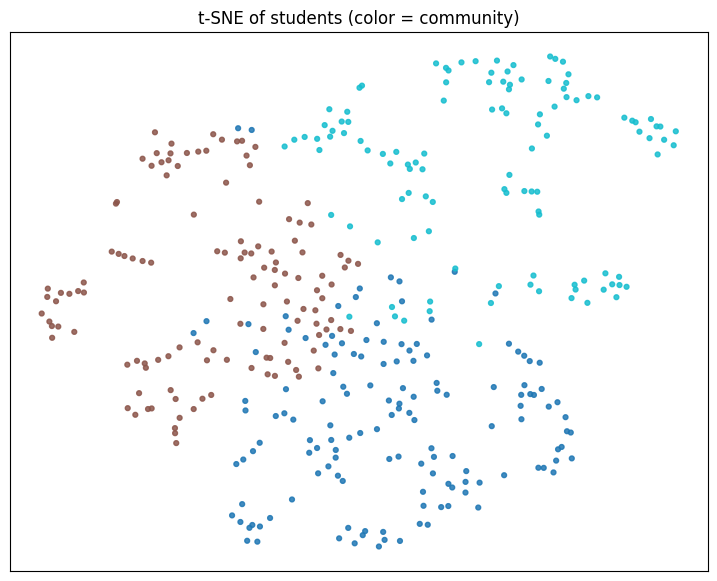

In [58]:
ids = list(G.nodes())
A = nx.to_numpy_array(G, nodelist=ids, weight="weight")

perp = max(5, min(30, A.shape[0] // 50))
tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            perplexity=perp, random_state=42)
Y = tsne.fit_transform(A)

emb = pd.DataFrame(Y, columns=["x","y"], index=ids)
emb["community"] = pd.Series(part)

plt.figure(figsize=(9,7))
plt.scatter(
    emb["x"], emb["y"],
    s=12,
    c=emb["community"].astype("category").cat.codes,
    cmap="tab10", alpha=0.85
)
plt.title("t-SNE of students (color = community)")
plt.xticks([]); plt.yticks([])
plt.show()

embedding_df = emb.copy() 


We also use t-SNE to visualize all students in 2D.
This projection helps to confirm the presence of three main communities detected earlier.
Even if t-SNE does not change the analysis, it gives a clear view of how students are grouped based on their similarity in online activity.”

### Part 7 : join communities with student info + analyse outcome

In [ ]:
# join communities to student metadata to analyze final_result per community
comm_df = pd.Series(part, name="community").to_frame()
meta = student_data.set_index("id_student").loc[X.index]  
res = meta.join(comm_df) # per line : one student with his community and his result final  

sizes = pd.Series(part).value_counts().sort_values(ascending=False) # how many student in each communitie
print("Modularity:", round(modularity, 3))
display(sizes.to_frame("n_students"))

# proportions of final_result per community
tab = (res.groupby("community")["final_result"]
         .value_counts(normalize=True)
         .rename("proportion")
         .reset_index())

display(tab.sort_values(["community","proportion"], ascending=[True,False]).head(30))

Modularity: 0.481


,n_students
0,140
1,124
2,114


,community,final_result,proportion
0,0,Pass,0.846154
1,0,Withdrawn,0.055944
2,0,Distinction,0.048951
3,0,Fail,0.048951
4,1,Pass,0.489796
5,1,Fail,0.251701
6,1,Withdrawn,0.251701
7,1,Distinction,0.006803
8,2,Pass,0.674797
9,2,Withdrawn,0.154472



We now link each student to their detected community and compare the academic results (final_result).

| Community | Number of students | Main results | Interpretation |
|------------|--------------------|---------------|----------------|
| **0** | 140 | 85% Pass, 5% Distinction | This is the **most successful group**. These students probably show regular activity and strong engagement on the online platform. |
| **1** | 124 | 49% Pass, 25% Fail, 25% Withdrawn | This is the **weakest group**. Many of these students failed or withdrew, suggesting lower participation or motivation. |
| **2** | 114 | 67% Pass, 10% Distinction | This group shows **average performance**. Their engagement may be moderate or irregular. |

**Interpretation:**  
The three detected communities correspond to three main learning profiles:
1. **Active and successful** students (community 0)  
2. **Irregular or disengaged** students (community 1)  
3. **Moderately active** students (community 2)

These patterns confirm that the graph-based community detection method helps to **identify meaningful behavioral groups** among students, closely related to their academic outcomes.


### Part 8 : what characterize each communities ? 

In [ ]:
# compare the 3 communities by their activity

# add community info to the student activity matrix
comm_series = pd.Series(part, name="community")
X_with_comm = X_raw.copy()
X_with_comm["community"] = comm_series

# we now compute the average number of clicks per resource for each community
mean_by_comm = X_with_comm.groupby("community").mean()

# after we compute total average clicks per student (sum of clicks on all resources)
total_clicks = mean_by_comm.sum(axis=1).sort_index()

print("Average total clicks per community:")
display(total_clicks.to_frame("avg_total_clicks"))

# for each communiti, show the top 3 most visited resources
for c in mean_by_comm.index:
    print(f"\ntop 3 resources in community {c}:")
    top3 = mean_by_comm.loc[c].sort_values(ascending=False).head(3)
    display(top3.to_frame("avg_clicks"))


💡 Average total clicks per community:


,avg_total_clicks
community,
0,1641.064286
1,658.951613
2,2956.447368



📘 Top 3 resources in community 0:


,avg_clicks
id_site,
546614,344.542857
546654,59.692857
546732,57.100000



📘 Top 3 resources in community 1:


,avg_clicks
id_site,
546614,151.290323
546879,36.500000
546657,27.959677



📘 Top 3 resources in community 2:


,avg_clicks
id_site,
546614,643.412281
546657,214.640351
546644,162.473684


### Part 9 : study of parameter = modularity vs k 

In [63]:
# Try different k values to see structure strength
results = []
for k in [5, 10, 15, 25]:
    Gk = gs.build_knn_graph(sim, student_ids=X.index.tolist(), k=k, sim_threshold=SIM_THRESHOLD)
    partk = gs.detect_communities(Gk)
    modk = gs.compute_modularity(Gk, partk)
    results.append({"k": k, "modularity": modk, "edges": Gk.number_of_edges()})

pd.DataFrame(results)

,k,modularity,edges
0,5,0.573939,1531
1,10,0.480554,3053
2,15,0.414812,4508
3,25,0.374211,7416
